# 3. Convolutional LSTM

## 데이터 수집

In [98]:
from pandas_datareader import data as pdr
import yfinance as yfin
from datetime import date, datetime

today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = datetime(2013,1,1)

# BTC(KRW)
yfin.pdr_override()

btc_krwname = 'Bitcoin(KRW)'
btc_krw = 'BTC-KRW'
btc_krw_df = pdr.get_data_yahoo(btc_krw, start=date_start, end=date_today)

print(btc_krw_df.shape)
btc_krw_df

[*********************100%***********************]  1 of 1 completed
(3178, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,4.826118e+05,4.838110e+05,4.681210e+05,4.732035e+05,4.732035e+05,21787470960
2014-09-18,4.727130e+05,4.762765e+05,4.309914e+05,4.428182e+05,4.428182e+05,35976322560
2014-09-19,4.424667e+05,4.475154e+05,4.012784e+05,4.119893e+05,4.119893e+05,39571102935
2014-09-20,4.118610e+05,4.417305e+05,4.068624e+05,4.267118e+05,4.267118e+05,38469009780
2014-09-21,4.258571e+05,4.303872e+05,4.103040e+05,4.161897e+05,4.161897e+05,27737663355
...,...,...,...,...,...,...
2023-05-26,3.472378e+07,3.536380e+07,3.423304e+07,3.524552e+07,3.524552e+07,18438822300836
2023-05-27,3.524283e+07,3.568314e+07,3.491508e+07,3.536111e+07,3.536111e+07,16822938231443
2023-05-28,3.536229e+07,3.558556e+07,3.523122e+07,3.555838e+07,3.555838e+07,10444529598313


In [99]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata

# 데이터 분할
train_size = int(len(btc_krw_df) * 0.8)
train_data = btc_krw_df[:train_size]
test_data = btc_krw_df[train_size:]

# 분위수 정규화 수행
normalized_train_data = rankdata(train_data['Adj Close']) / len(train_data)
normalized_test_data = rankdata(test_data['Adj Close']) / len(test_data)

# 추세 제거를 위한 이동평균 계산
window = 60 # 이동평균 윈도우 크기
rolling_mean_train = pd.Series(normalized_train_data).rolling(window=window, min_periods=1).mean()
rolling_mean_test = pd.Series(normalized_test_data).rolling(window=window, min_periods=1).mean()

# 추세 제거
detrended_train_data = normalized_train_data - rolling_mean_train
detrended_test_data = normalized_test_data - rolling_mean_test

# 시계열 데이터 추출
sequence_length = 30 # 입력 시퀀스 길이
X_train = []
y_train = []
for i in range(len(detrended_train_data) - sequence_length):
    X_train.append(detrended_train_data[i:i + sequence_length])
    y_train.append(detrended_train_data[i + sequence_length])
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []
for i in range(len(detrended_test_data) - sequence_length):
    X_test.append(detrended_test_data[i:i + sequence_length])
    y_test.append(detrended_test_data[i + sequence_length])
X_test = np.array(X_test)
y_test = np.array(y_test)

Epoch 1/100
 4/79 [>.............................] - ETA: 1s - loss: 0.0030  

KeyboardInterrupt: 

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# 데이터 분할
train_size = int(len(btc_krw_df) * 0.8)
train_data = btc_krw_df[:train_size]
test_data = btc_krw_df[train_size:]

# 정규화를 위한 스케일링
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Adj Close']])
test_scaled = scaler.transform(test_data[['Adj Close']])

# 시계열 데이터 추출
sequence_length = 30  # 입력 시퀀스 길이

def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Convolutional LSTM 모델 구축
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Dropout(0.1))
model.add(LSTM(units=64, activation='tanh', return_sequences=True))
model.add(LSTM(units=64, activation='tanh'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Early Stopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

# 학습 데이터 예측
train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions).flatten()

# 테스트 데이터 예측
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions).flatten()

Epoch 1/100
79/79 [==============================] - 6s 33ms/step - loss: 0.0282 - val_loss: 0.0037
Epoch 2/100
79/79 [==============================] - 2s 23ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 3/100
79/79 [==============================] - 2s 23ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 4/100
79/79 [==============================] - 2s 24ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 5/100
79/79 [==============================] - 2s 23ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 6/100
79/79 [==============================] - 2s 24ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 7/100
79/79 [==============================] - 2s 23ms/step - loss: 9.5435e-04 - val_loss: 0.0031
Epoch 8/100
79/79 [==============================] - 2s 23ms/step - loss: 8.6235e-04 - val_loss: 0.0036
Epoch 9/100
79/79 [==============================] - 2s 23ms/step - loss: 8.5092e-04 - val_loss: 0.0032
Epoch 10/100
79/79 [==============================] - 2s 22ms/step - loss: 8.3593e-04 - 

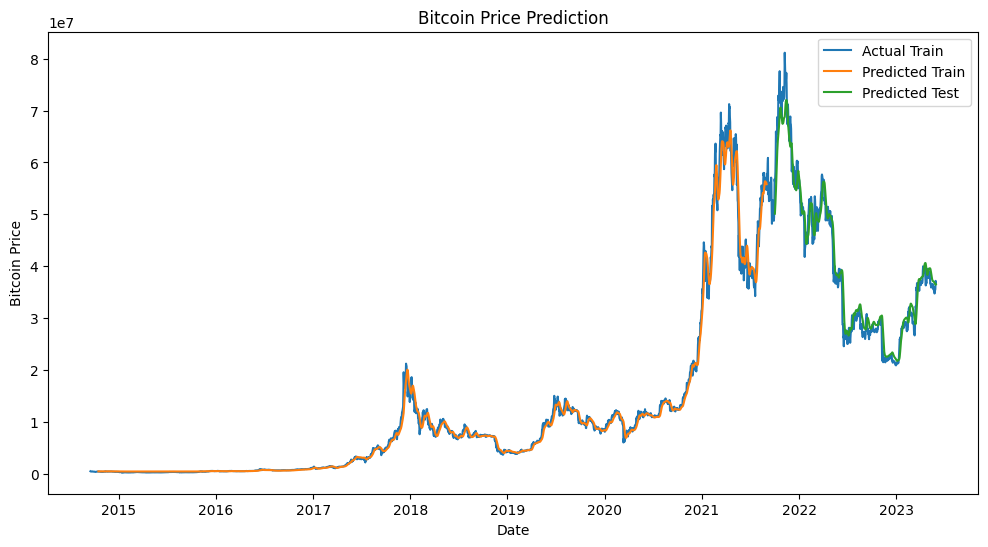

In [122]:
# 시각화
plt.figure(figsize=(12, 6))
plt.plot(btc_krw_df['Adj Close'], label='Actual Train')
plt.plot(train_data.index[sequence_length:], train_predictions, label='Predicted Train')
plt.plot(test_data.index[sequence_length:], test_predictions, label='Predicted Test')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

Mean Squared Error (MSE): 1770604444442898.5
Mean Absolute Error (MAE): 39847421.98064191
R-squared (R2): -4.070474572296763e+16


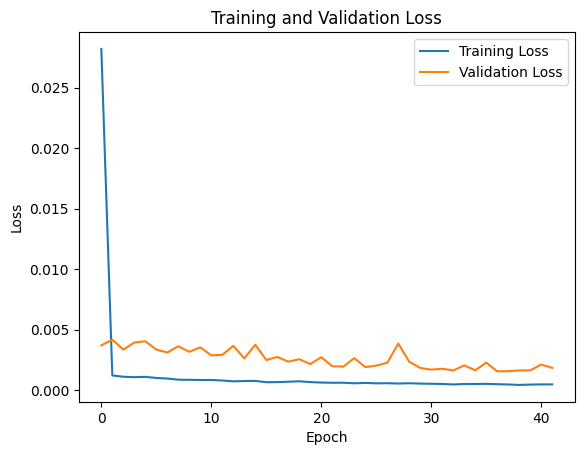

In [123]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 성능 지표 계산
test_mse = mean_squared_error(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# 성능 지표 출력
print("Mean Squared Error (MSE):", test_mse)
print("Mean Absolute Error (MAE):", test_mae)
print("R-squared (R2):", test_r2)# Loss 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 32ms/step


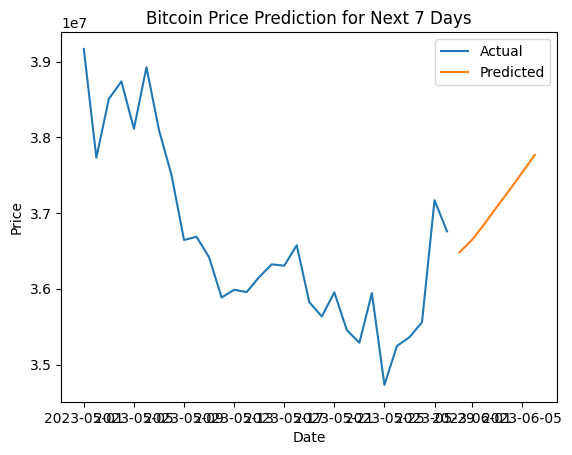

In [126]:
# 테스트 데이터의 마지막 시퀀스 추출
last_sequence = X_test[-1]

# 다음 7일 가격 예측
predicted_prices = []
for _ in range(7):
    # 현재 시퀀스로 가격 예측
    prediction = model.predict(np.expand_dims(last_sequence, axis=0))
    predicted_prices.append(prediction[0, 0])

    # 예측 결과를 이용해 다음 시퀀스 생성
    last_sequence = np.concatenate((last_sequence[1:], [[prediction[0, 0]]]))

# 예측 결과를 역스케일링
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()

# 결과 시각화
plt.plot(test_data.index[-30:], test_data['Adj Close'].values[-30:], label='Actual')
plt.plot(pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=7), predicted_prices, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price Prediction for Next 7 Days')
plt.legend()
plt.show()